# Which one is a better plan?

The hypothetical telecom operator Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

This project is notable among data investigions due to the relatively small client selection. Faced with only 500 Megaline clients, we need to analyze the clients' behavior and determine which prepaid plan brings in more revenue. We will clean and prepare the data, ensure all data is an appropriate type, and no duplicate or missing values exist. Then we will engineer features we believe to be useful later. I will analyze the user data before performing scipy hypothesis testing on our findings, and ultimately conclude which prepaid plan brings in more revenue.

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
from matplotlib import pyplot as plt

## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv('./datasets/megaline_calls.csv')
internet = pd.read_csv('./datasets/megaline_internet.csv')
messages = pd.read_csv('./datasets/megaline_messages.csv')
users = pd.read_csv('./datasets/megaline_users.csv')
plans = pd.read_csv('./datasets/megaline_plans.csv')

## Summarize and prepare the data

### The `Calls` Data

In [3]:
# Basic info and a couple samples
display(calls.info())
display(calls.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


None

,id,user_id,call_date,duration
80309,1289_234,1289,2018-11-19,6.08
6024,1029_188,1029,2018-11-27,10.88
2179,1009_601,1009,2018-06-30,0.00
101034,1361_136,1361,2018-08-22,8.40
43785,1159_381,1159,2018-08-25,17.18


The 'id' entry for each call looks to have been generated by taking the 'user_id,' adding an underscore, and ending with a unique number.

We will want to convert the 'call_date' column to datetime below. According to the Megaline data, all calls' duration must be rounded up to the nearest minute, so we will need to round up the 'duration' column and convert to int64. Some calls are of duration 0, but we have no reason in the company's documentation to suggest that a value of zero is erroneous (it likely indicates a call was placed but did not go through).

I will do a quick check for duplicates:

In [4]:
# Check for duplicate ids
display(calls[calls['id'].duplicated()])

,id,user_id,call_date,duration


There do not appear to be duplicate calls.

### The `Internet` Data

In [5]:
# Basic info and a couple samples
display(internet.info())
display(internet.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


None

,id,user_id,session_date,mb_used
46072,1204_5,1204,2018-11-29,821.90
38579,1172_234,1172,2018-12-08,658.99
32848,1147_500,1147,2018-06-12,126.83
63052,1291_177,1291,2018-05-26,0.00
81217,1380_207,1380,2018-12-26,0.00


The 'id' entry for each session looks to have been generated by taking the 'user_id,' adding an underscore, and ending with a unique number.

We will want to convert the 'session_date' column to datetime below.

I will quickly check for duplicate sessions:

In [6]:
# Check for duplicate ids
display(internet[internet['id'].duplicated()])

,id,user_id,session_date,mb_used


There do not appear to be duplicate sessions, either.

### The `Messages` Data

In [7]:
#Basic info and a couple samples
display(messages.info())
display(messages.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


None

,id,user_id,message_date
36721,1246_25,1246,2018-07-18
51649,1335_239,1335,2018-07-23
66063,1433_3,1433,2018-12-14
65576,1421_161,1421,2018-12-09
66362,1433_302,1433,2018-10-20


The 'id' entry for each session looks to have been generated by taking the 'user_id,' adding an underscore, and ending with a unique number.

We will want to convert the 'message_date' column to datetime below.

I will quickly check for duplicates:

In [8]:
# Check for duplicate ids
display(messages[messages['id'].duplicated()])

,id,user_id,message_date


There do not appear to be duplicate messages.

### The `Users` Data

In [9]:
# Basic info and a couple samples
display(users.info())
display(users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
471,1471,Britni,Mitchell,59,"Richmond, VA MSA",2018-10-13,surf,NaN
145,1145,Venice,Brooks,29,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-12,surf,NaN
224,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaN
421,1421,Zane,Hobbs,26,"Phoenix-Mesa-Chandler, AZ MSA",2018-05-18,surf,NaN
15,1015,Beata,Carpenter,26,"Pittsburgh, PA MSA",2018-12-05,surf,NaN


The 'id' entry for each session looks to have been generated by taking the 'user_id,' adding an underscore, and ending with a unique number.

We will want to convert the 'reg_date' and 'churn_date' columns to datetime below. There are a lot of missing items in the 'churn_date' columns, but the documentation indicates that missing data here indicates the plan was still active when the database was extracted. We'll leave the NaNs.

I will do a quick survey of the ids, as there could be duplicates hiding:

In [10]:
# Check for duplicate user ids
display(users[users['user_id'].duplicated()])

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date


There do not appear to be duplicate users. Finally, I will check the 'plans' column to ensure there are only two plans represented, and to count the relative number of users on each plan.

In [11]:
# Count users on each plan
display(users['plan'].value_counts())

plan
surf        339
ultimate    161
Name: count, dtype: int64

There are just over twice as many clients on the Surf plan as are on the Ultimate plan.

### The `Plans` Data

In [12]:
# Print the general/summary information about the plans' DataFrame
display(plans.info())

# Print a sample of data for plans
display(plans)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The above numbers are primarily of data type int64, except for those denoting fractions of USD (cents) in the 'usd_per_message' and 'usd_per_minute' columns. The Surf plan appears to be intended for clients who will use less data and traffic, and pricing scales three times as sharply after going over usage limits than the Ultimate plan. The Ultimate plan has similar data included in the plan compared to the Surf plan (only twice what the Surf plan offers), but it has 6 times the minutes included and 20 times the messages included. The plans clearly expect similar client usage of data per month, but a difference for some users in the amount of messages and calls they make.

There is a discrepancy in units, however, as the 'mb_per_month_included' column uses megabytes (mb), while the 'usd_per_gb' column uses gigabytes (gb). I believe it is worth adding a column for gb_per_month_included to keep units straight during later calculations. 

## Fix and enrich the data

### Calls

#### Fix data

Based on the summary analysis above, we determined we needed to convert the 'call_date' column to datetime and round up the 'duration' column and convert to int64. We can do this here and sample the result.

In [13]:
# Convert to datetime. Sample: 2018-10-28
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Round up the durations to nearest minute and convert to int64
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int64')

# Print corrected output
calls.info()
display(calls.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
18699,1071_568,1071,2018-11-19,10
18634,1071_484,1071,2018-07-27,0
42062,1155_3,1155,2018-05-26,6
27986,1106_325,1106,2018-08-02,5
132545,1477_101,1477,2018-11-07,18


#### Enrich data

We could add a column that indicates cost per call somehow, but the `calls` dataframe does not have information on pricing or plan subscription. We'd be making two columns unnecessarily unless we cross-referenced to the `plans` dataframe. Instead, to make later processing easier, I'll add a 'month' column.

In [14]:
# Access the month attribute of each call_date
calls['month'] = calls['call_date'].dt.month
display(calls.sample(5))

,id,user_id,call_date,duration,month
115059,1403_133,1403,2018-12-15,0,12
116968,1408_617,1408,2018-05-28,13,5
120439,1420_9,1420,2018-08-03,1,8
110851,1390_300,1390,2018-08-03,16,8
109575,1386_35,1386,2018-11-22,15,11


### Internet

#### Fix Data

Based on the summary analysis above, we determined we needed to convert the 'session_date' column to datetime. We do not need to round the 'mb_used' column as the documentation shows individual web sessions are not rounded up in the plan pricing. We can do this here and sample the result.

In [15]:
# Convert to datetime. Sample: 2018-10-28
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# Print corrected output
internet.info()
display(internet.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
15726,1071_364,1071,2018-06-19,249.69
95699,1446_213,1446,2018-12-02,922.27
62863,1290_20,1290,2018-11-26,444.30
24773,1114_34,1114,2018-08-08,479.86
1828,1009_363,1009,2018-07-07,174.52


#### Enrich Data

We could add a column that indicates cost per session somehow, but the `internet` dataframe does not have information on pricing or plan subscription. We'd be making two columns unnecessarily unless we cross-referenced to the `plans` dataframe. Instead, to make later processing easier, I'll add a 'month' column.

In [16]:
#Access the .dt.month attribute of each session_date
internet['month'] = internet['session_date'].dt.month
display(internet.sample(5))

,id,user_id,session_date,mb_used,month
28941,1132_399,1132,2018-08-23,868.07,8
73946,1347_41,1347,2018-08-02,394.93,8
30113,1138_346,1138,2018-05-16,715.40,5
84043,1392_11,1392,2018-12-21,452.08,12
87463,1405_244,1405,2018-11-26,659.13,11


### Messages

#### Fix data

Based on the summary analysis above, we determined we needed to convert the 'message_date' column to datetime. We can do this here and sample the result.

In [17]:
# Convert to datetime. Sample: 2018-10-28
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# Print corrected output
messages.info()
display(messages.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


,id,user_id,message_date
15892,1105_91,1105,2018-12-05
38083,1251_135,1251,2018-09-27
48246,1324_978,1324,2018-11-27
57046,1362_114,1362,2018-10-01
52813,1337_57,1337,2018-12-13


#### Enrich data

We could add a column that indicates cost per message somehow, but the `messages` dataframe does not have information on pricing or plan subscription. We'd be making two columns unnecessarily unless we cross-referenced to the `plans` dataframe. Instead, to make later processing easier, I'll add a categorical 'month' column to the dataframe:

In [18]:
# Access the month attribute of each message_date
messages['month'] = messages['message_date'].dt.month
display(messages.sample(5))

,id,user_id,message_date,month
70706,1460_204,1460,2018-06-22,6
17687,1114_793,1114,2018-11-20,11
10925,1077_196,1077,2018-09-07,9
42232,1273_267,1273,2018-12-20,12
44380,1294_161,1294,2018-11-01,11


### Users

#### Fix data

Based on the summary analysis above, we determined we needed to convert the 'reg_date' and 'churn_date' columns to datetime. We can do this here and sample the result. We are leaving NaNs (now NaTs) in as they are useful pieces of information.

In [19]:
# Convert to datetime. Sample: 2018-10-28
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# Print corrected output
users.info()
display(users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
476,1476,Tammara,Dorsey,24,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-06-10,ultimate,NaT
131,1131,Shane,Morrison,60,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-01-07,surf,NaT
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
310,1310,Vincent,Fry,73,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-11-29,surf,NaT
97,1097,Deandre,Powell,27,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-02-26,surf,NaT


#### Enrich data

No features should be engineered here. We could represent NaT values for 'churn_date' as a categorical column (i.e. an 'active_plan' column that indicates whether they have churned their plan or not). However, we can simply test for NaT in the 'churn_date' column. Since we do all calculations below in aggregate, we can leave the `users` dataframe as-is.

### Plans

#### Fix data

Based on the summary analysis above, we do not need to make any changes to the existing data in the `plans` dataframe.

#### Enrich data

Due to the calculations in the documentation revolving around gigabytes, it would be useful to simply add the gigabyte data for the plans in the `plans` dataframe. It will make for slightly cleaner code later on.

In [20]:
# Add a column for gb per month as all calculations below will be in gigabytes
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].astype('int64')

display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Study plan conditions

As we can see from the above display, the plans have different thresholds of internet data, call minutes, and messages allowed without extra charge. Once users go past those amounts, they are charged for every gigabyte, message, and minute over at a flat rate for each that differs between plans.

To ensure we understand how plans are priced, I will create two test user rows and two pricing functions and pass it through that function. We will use this function later to calculate price aggregately.

In [21]:
# Create test users
cols = ['user_id', 'month', 'messages', 'gb_used', 'minutes', 'plan']
sample_users = pd.DataFrame(data=[
    [
        94,
        3,
        104,
        18,
        857,
        'surf'
    ],
    [
        95,
        3,
        1498,
        39,
        5278,
        'ultimate'
    ]
], columns=cols)

def overcharge_lookup(plan_name, price_type, count):
    """
    This helper function searches the `plans` dataframe for the relevant information and spits out the corresponding charge
    for one of the three kinds of prices. It only returns a value greater than 0 if the user went over their 
    monthly limit.
    
    If the column names ever change, this function needs to be updated.
    """
    
    if price_type == 'messages':
        plan_threshold = plans[plans['plan_name'] == plan_name].iloc[0]['messages_included']
        plan_rate = plans[plans['plan_name'] == plan_name].iloc[0]['usd_per_message']
    elif price_type == 'gb_data':
        plan_threshold = plans[plans['plan_name'] == plan_name].iloc[0]['gb_per_month_included']
        plan_rate = plans[plans['plan_name'] == plan_name].iloc[0]['usd_per_gb']
    elif price_type == 'call_minutes':
        plan_threshold = plans[plans['plan_name'] == plan_name].iloc[0]['minutes_included']
        plan_rate = plans[plans['plan_name'] == plan_name].iloc[0]['usd_per_minute']
    else:
        return NaN
    
    return plan_rate*(max(0, count - plan_threshold))

def calculate_charge(row):
    """
    This function returns a charge for each user's monthly activity based on their plan in USD.
    """
    
    #Initialize total_charge to the base monthly pay for the plan 
    total_charge = plans[plans['plan_name'] == row['plan']].iloc[0]['usd_monthly_pay']
    
    #Add on each type of overcharge
    total_charge += overcharge_lookup(row['plan'], 'messages', row['messages'])
    total_charge += overcharge_lookup(row['plan'], 'gb_data', np.ceil(row['gb_used'])) #Round up the gb here
    total_charge += overcharge_lookup(row['plan'], 'call_minutes', row['minutes'])
    return total_charge

sample_users['monthly_charge'] = sample_users.apply(calculate_charge, axis=1)
    
display(sample_users)

,user_id,month,messages,gb_used,minutes,plan,monthly_charge
0,94,3,104,18,857,surf,62.33
1,95,3,1498,39,5278,ultimate,160.76


## Aggregate data per user

Now, as the data is clean, we aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.

In [22]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_user_per_month = calls.groupby(['user_id', 'month'])['id'].count().rename('calls')
display(calls_per_user_per_month.sample(5))

user_id  month
1060     10       98
1027     7        46
1456     8        67
1347     10       54
1380     12       84
Name: calls, dtype: int64

In [23]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_user_per_month = calls.groupby(['user_id', 'month'])['duration'].sum().rename('minutes')
display(minutes_per_user_per_month.sample(5))

user_id  month
1361     8        354
1226     11       429
1255     10       493
1396     11       279
1425     10       257
Name: minutes, dtype: int64

In [24]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_user_per_month = messages.groupby(['user_id', 'month'])['id'].count().rename('messages')
display(messages_per_user_per_month.sample(5))

user_id  month
1254     10       106
1250     10        53
1316     5         14
1455     11        68
1405     6         24
Name: messages, dtype: int64

In [25]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
data_per_user_per_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().rename('gb_used')

"""
The documentation indicates that data should be rounded up to the nearest gigabyte. 
Therefore, we first convert to gigabytes, and then we round up using np.ceil().
Finally, we convert to int64.
"""
data_per_user_per_month = np.ceil(data_per_user_per_month / 1024).astype('int64')
display(data_per_user_per_month.sample(5))

user_id  month
1141     10       16
1028     11       42
1198     9        13
1467     7        15
1021     12        6
Name: gb_used, dtype: int64

We will concatenate all data series into a multi-index dataframe representing all user usage for each month.

In [26]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
usage_per_user_per_month = pd.concat([
    calls_per_user_per_month, minutes_per_user_per_month, messages_per_user_per_month, data_per_user_per_month
    ], axis='columns'
)

# Print
display(usage_per_user_per_month.sample(5))

,,calls,minutes,messages,gb_used
user_id,month,,,,
1196,1,42.0,287.0,23.0,9.0
1445,6,65.0,528.0,11.0,15.0
1044,12,39.0,312.0,31.0,16.0
1353,9,60.0,444.0,NaN,13.0
1232,8,79.0,635.0,NaN,16.0


We have some NaN values where we did not before. This indicates instances where a user had an active subscription but didn't use one of the categories of service provided (e.g. they made calls but didn't send messages). That is why they appeared during concatenation -- missing values had to be added to fill in the dataframe. 

We can replace all NaNs with zeros and reset the type of data to int64. Finally, we should reset the index so that 'user_id' and 'month' are columns.

In [27]:
# Replace all NaNs with zeros, then cast to int64
usage_per_user_per_month = usage_per_user_per_month.fillna(0)
usage_per_user_per_month = usage_per_user_per_month.astype('int64')

# Reset index
usage_per_user_per_month.reset_index(inplace=True)

# Print
display(usage_per_user_per_month.sample(5))

,user_id,month,calls,minutes,messages,gb_used
802,1171,10,41,324,0,26
373,1078,12,14,86,32,13
1306,1285,11,54,314,25,3
18,1005,12,59,496,11,17
2130,1470,6,72,565,133,0


In [28]:
# Add the plan information.
agg_monthly_user_info = usage_per_user_per_month.merge(users, on='user_id')

# Print
display(agg_monthly_user_info.sample(5))

,user_id,month,calls,minutes,messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date
477,1101,10,63,474,78,16,Sage,Conley,27,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-02-08,surf,NaT
285,1063,11,9,67,0,11,Larhonda,Hartman,60,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-05,ultimate,NaT
506,1109,10,67,602,0,11,Dominic,Salinas,41,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-16,surf,NaT
1361,1299,12,58,435,10,12,Keitha,Harrison,64,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-19,surf,NaT
1864,1406,4,52,358,0,19,Noble,Jefferson,54,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-03-04,surf,NaT


There is a chance that data has entered after a user has churned their subscription, or before they have activated their plan. I will do a check to make 100% certain that this is not the case:

In [29]:
# Create new column
agg_monthly_user_info['churn_month'] = agg_monthly_user_info['churn_date'].dt.month
agg_monthly_user_info['activated_month'] = agg_monthly_user_info['reg_date'].dt.month

# Print instances where the month entry is outside the active subscription, which should never be the case
display(agg_monthly_user_info.query('month > churn_month or month < activated_month'))

,user_id,month,calls,minutes,messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,churn_month,activated_month
54,1012,12,16,78,0,12,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,11.0,6
80,1022,10,83,574,0,19,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,9.0,4
81,1022,11,72,498,0,22,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,9.0,4
82,1022,12,82,585,0,18,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,9.0,4
212,1050,11,57,413,0,14,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,10.0,3
213,1050,12,52,299,0,17,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,10.0,3
311,1067,12,53,344,20,16,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24,11.0,9
403,1084,12,103,720,81,28,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11,11.0,6
497,1106,12,67,569,0,22,Eddy,Garrison,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-10,surf,2018-11-14,11.0,5
809,1172,12,90,711,117,24,Weldon,Robinson,72,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-30,surf,2018-11-29,11.0,3


In [30]:
# We can fix this by REMOVING instances where churn_month < month and activated_month > month
agg_monthly_user_info = agg_monthly_user_info[
    ((agg_monthly_user_info['churn_month'].isna()) |
    (agg_monthly_user_info['churn_month'] >= agg_monthly_user_info['month']))]
agg_monthly_user_info = agg_monthly_user_info[agg_monthly_user_info['activated_month'] <= agg_monthly_user_info['month']]

We should take this information and get a monthly charge for each user's monthly usage data, which turns into the company's revenue. I'll save the monthly charge to the `agg_monthly_user_info` dataframe.

In [31]:
# Calculate the monthly revenue for each user. We will be using the function we created in section 1.5 to calculate charge.
agg_monthly_user_info['monthly_charge'] = agg_monthly_user_info.apply(calculate_charge, axis=1)

# Print
display(agg_monthly_user_info.sample(5))

,user_id,month,calls,minutes,messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,churn_month,activated_month,monthly_charge
1288,1280,12,84,610,55,18,Jasper,Berry,29,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-23,surf,NaT,NaN,6,53.45
591,1127,10,27,168,12,24,Marchelle,Brock,28,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-23,surf,NaT,NaN,6,110.00
976,1210,9,38,272,0,8,Shanae,Carrillo,30,"Oklahoma City, OK MSA",2018-06-01,surf,NaT,NaN,6,20.00
730,1156,10,64,414,0,20,Anette,Chambers,71,"Albuquerque, NM MSA",2018-03-25,surf,NaT,NaN,3,70.00
645,1140,10,102,869,16,17,Randolph,Graves,53,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-26,surf,NaT,NaN,3,51.07


In [32]:
agg_monthly_user_info['monthly_charge'].unique()

array([ 70.  ,  20.  ,  90.09,  60.  , 158.12,  80.  , 110.  , 150.  ,
        90.  ,  40.  ,  84.  , 110.03, 244.62, 110.72, 163.51,  71.02,
        69.69, 181.4 , 116.93,  88.28, 107.2 , 126.42, 117.68,  74.68,
        30.96,  41.59,  25.94,  74.11,  43.03,  46.33,  38.84,  50.54,
       144.47, 160.11,  24.08, 152.34, 100.  ,  83.93,  20.3 ,  21.92,
        30.  , 112.  , 119.  ,  91.  , 126.  , 140.  , 182.  , 154.  ,
        27.89,  55.76,  24.14,  83.96,  34.29, 168.  ,  77.  , 122.01,
        43.69,  90.3 , 120.21, 120.66, 132.28, 120.  ,  24.32,  20.06,
       167.48,  70.33,  50.  ,  20.54,  30.87,  21.32,  20.72,  70.66,
        21.35,  30.84, 105.  ,  21.98,  24.38, 135.22, 116.27,  62.85,
       129.81,  93.96,  41.89,  54.32,  20.84,  46.69,  73.78,  80.42,
        50.3 ,  72.46,  20.63,  21.26, 143.9 , 143.42, 200.  , 210.  ,
        20.93,  20.42,  20.03, 123.18, 102.85,  83.27,  82.67,  32.46,
        90.86,  55.49,  47.59,  26.09,  31.19,  26.15,  54.95,  21.47,
      

In [33]:
# Ensure only cents data exists in 'monthly_charge'
agg_monthly_user_info['monthly_charge'] = np.ceil(agg_monthly_user_info['monthly_charge']*100)/100
agg_monthly_user_info['monthly_charge'].unique()

array([ 70.  ,  20.  ,  90.09,  60.  , 158.12,  80.  , 110.  , 150.  ,
        90.  ,  40.  ,  84.  , 110.03, 244.62, 110.72, 163.51,  71.02,
        69.69, 181.4 , 116.93,  88.28, 107.2 , 126.42, 117.68,  74.69,
        30.96,  41.59,  25.94,  74.11,  43.03,  46.33,  38.85,  50.54,
       144.47, 160.12,  24.08, 152.34, 100.  ,  83.93,  20.3 ,  21.92,
        30.  , 112.  , 119.  ,  91.  , 126.  , 140.  , 182.  , 154.  ,
        27.89,  55.76,  24.14,  83.96,  34.29, 168.  ,  77.  , 122.01,
        43.69,  90.3 , 120.21, 120.66, 132.28, 120.  ,  24.32,  20.06,
       167.48,  70.33,  50.  ,  20.54,  30.87,  21.32,  20.72,  70.66,
        21.35,  30.84, 105.  ,  21.98,  24.38, 135.22, 116.27,  62.85,
       129.81,  93.96,  41.89,  54.32,  20.84,  46.69,  73.78,  80.42,
        50.3 ,  72.46,  20.63,  21.26, 143.9 , 143.42, 200.  , 210.  ,
        20.93,  20.43,  20.03, 123.18, 102.85,  83.27,  82.67,  32.46,
        90.86,  55.49,  47.59,  26.09,  31.19,  26.15,  54.95,  21.47,
      

## Study user behaviour

### Prep plan data

Before diving deeper, we'll create a few divisions of the data and save them to separate variables for more efficient and clean code later. All later analysis will be based on the dataframes created here.

In [34]:
# Separate data by plan
surf_monthly_user_data = agg_monthly_user_info.query('plan=="surf"')
ultimate_monthly_user_data = agg_monthly_user_info.query('plan=="ultimate"')

# Separate call data while keeping user_id and month info
surf_monthly_call_data = surf_monthly_user_data.loc[:, ['user_id', 'month', 'calls', 'minutes']]
ultimate_monthly_call_data = ultimate_monthly_user_data.loc[:, ['user_id', 'month', 'calls', 'minutes']]

# Separate gb_used data while keeping user_id and month info
surf_monthly_gb_used_data = surf_monthly_user_data.loc[:, ['user_id', 'month', 'gb_used']]
ultimate_monthly_gb_used_data = ultimate_monthly_user_data.loc[:, ['user_id', 'month', 'gb_used']]

# Separate message data while keeping user_id and month info
surf_monthly_message_data = surf_monthly_user_data.loc[:, ['user_id', 'month', 'messages']]
ultimate_monthly_message_data = ultimate_monthly_user_data.loc[:, ['user_id', 'month', 'messages']]

# An array of month names for labeling
month_indices = range(12)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

An important visualization after studying the entries are the distribution of the number of active users across the months. I will quickly show a bar graph of the difference:

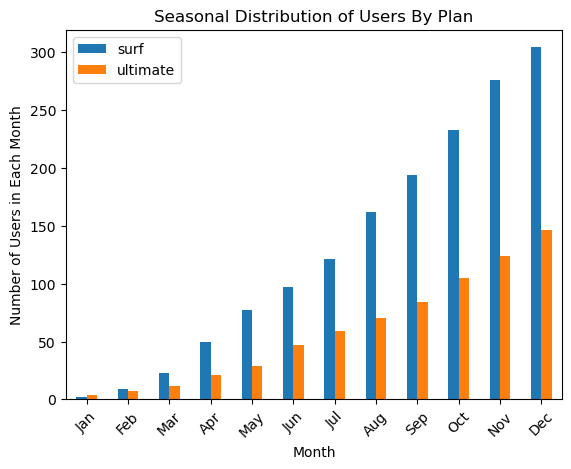

In [35]:
# Compare number of users per each plan per each distinct month.
monthly_users_surf = surf_monthly_user_data.groupby('month')['user_id'].count().rename('surf')
monthly_users_ultimate = ultimate_monthly_user_data.groupby('month')['user_id'].count().rename('ultimate')

monthly_users_per_plan = pd.concat([
    monthly_users_surf, monthly_users_ultimate
    ], axis='columns').reset_index()

monthly_users_per_plan.plot(x='month', kind='bar')
plt.title('Seasonal Distribution of Users By Plan')
plt.ylabel('Number of Users in Each Month')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

### Calls

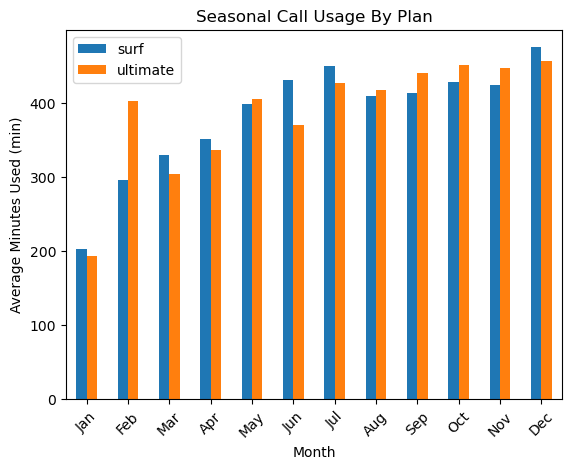

In [36]:
# Compare average duration of calls per each plan per each distinct month.
av_duration_per_month_surf = surf_monthly_call_data.groupby('month')['minutes'].mean().rename('surf')
av_duration_per_month_ultimate = ultimate_monthly_call_data.groupby('month')['minutes'].mean().rename('ultimate')

duration_per_plan_per_month = pd.concat([
    av_duration_per_month_surf, av_duration_per_month_ultimate
    ], axis='columns').reset_index()

duration_per_plan_per_month.plot(x='month', kind='bar')
plt.title('Seasonal Call Usage By Plan')
plt.ylabel('Average Minutes Used (min)')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

Based on the above graph, there does not seem to be a significant difference between average call durations between plans, which we will confirm later.

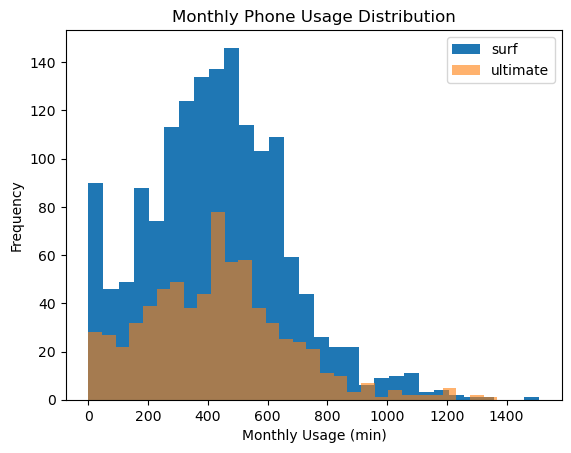

In [37]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
surf_monthly_call_data['minutes'].plot(
    kind='hist',
    bins=30,
    title='Monthly Phone Usage Distribution'
)
ultimate_monthly_call_data['minutes'].plot(
    kind='hist',
    bins=30,
    alpha=0.6)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Monthly Usage (min)')
plt.show()

The distributions are somewhat similar, indicating that having higher minute limits of the ultimate plan does not influence user behavior, and the average user will have comparable phone use regardless of plan.

In [38]:
# Calculate the mean and the variance of the monthly call duration
surf_mean_monthly_minutes = surf_monthly_call_data['minutes'].mean()
surf_var_monthly_minutes = np.var(surf_monthly_call_data['minutes'])

ultimate_mean_monthly_minutes = ultimate_monthly_call_data['minutes'].mean()
ultimate_var_monthly_minutes = np.var(ultimate_monthly_call_data['minutes'])

# Print
print('Mean and variance of monthly call minutes used')
display(pd.DataFrame([[
    surf_mean_monthly_minutes, surf_var_monthly_minutes
], [
    ultimate_mean_monthly_minutes, ultimate_var_monthly_minutes
]], columns=[
    'mean', 'variance',
], index=[
    'surf', 'ultimate'
]))

Mean and variance of monthly call minutes used


,mean,variance
surf,428.804264,55298.997217
ultimate,430.151130,57986.388177


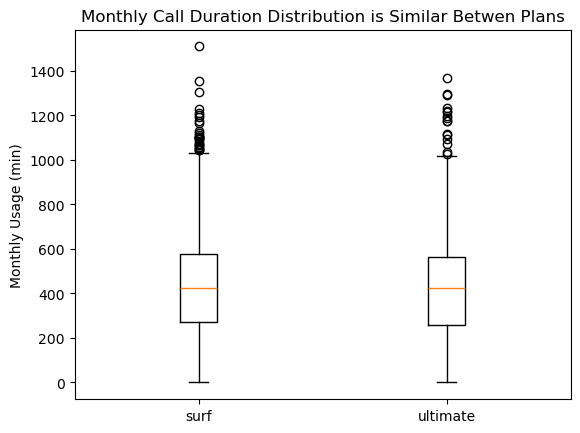

In [39]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.boxplot([surf_monthly_call_data['minutes'], ultimate_monthly_call_data['minutes']])
plt.xticks([1, 2], ['surf', 'ultimate'])
plt.ylabel('Monthly Usage (min)')
plt.title('Monthly Call Duration Distribution is Similar Betwen Plans')
plt.show()


Given the above visualizations and near-identical means and variances, there is no statistical difference in the user populations. If we theorize on the null hypothesis that there is no difference between the two population means, we cannot reject the hypothesis even with a generous alpha value of 0.1.

In [40]:
# Testing null hypothesis for two independent population means being equal
minutes_results = st.ttest_ind(surf_monthly_call_data['minutes'], ultimate_monthly_call_data['minutes'], equal_var=False)
print(f"P value equals {minutes_results.pvalue} and we cannot reject the null hypothesis.")

P value equals 0.901243968806006 and we cannot reject the null hypothesis.


### Messages

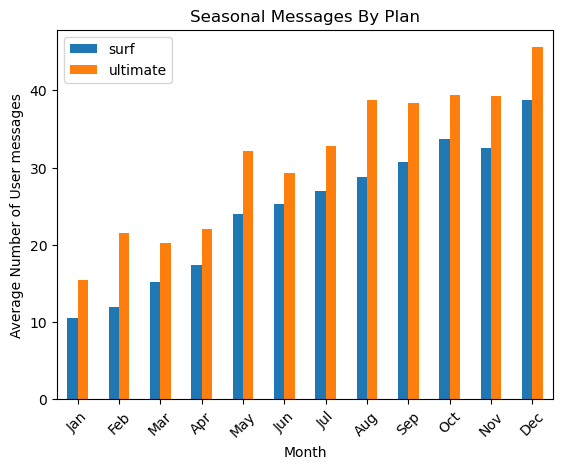

In [41]:
# Compare the number of messages users of each plan tend to send each month
av_messages_per_month_surf = surf_monthly_message_data.groupby('month')['messages'].mean().rename('surf')
av_messages_per_month_ultimate = ultimate_monthly_message_data.groupby('month')['messages'].mean().rename('ultimate')

av_messages_per_month_per_plan = pd.concat([
    av_messages_per_month_surf, av_messages_per_month_ultimate
    ], axis='columns').reset_index()

av_messages_per_month_per_plan.plot(x='month', kind='bar')
plt.title('Seasonal Messages By Plan')
plt.ylabel('Average Number of User messages')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

The ultimate users tend to have higher message usage -- by an average of about 5 or 6 messages more per month. The average number of messages does go up for both plans as the months go on. This might be due to database tracking or some industry forces we don't understand. It seems odd that the jump from December back to January would be so drastic and not follow a cyclic distribution.

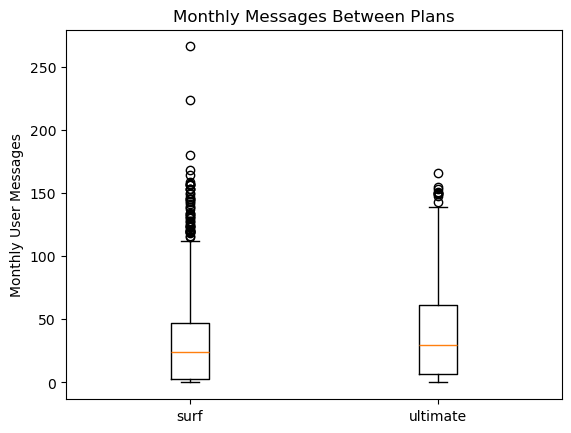

In [42]:
# Plot a boxplot to visualize the distribution of the monthly message usage
plt.boxplot([surf_monthly_message_data['messages'], ultimate_monthly_message_data['messages']])
plt.xticks([1, 2], ['surf', 'ultimate'])
plt.ylabel('Monthly User Messages')
plt.title('Monthly Messages Between Plans')
plt.show()

The boxplot is a great visualization of the average difference in plans. The Surf plan has more extreme outliers, but is more negatively skewed overall. Let's look at the null hypothesis that the populations are equal:

In [43]:
# Means of the message usage of each plan
av_surf_messages = surf_monthly_message_data['messages'].mean()
av_ultimate_messages = ultimate_monthly_message_data['messages'].mean()

# Print
print('Surf mean: {:.2f} messages'.format(av_surf_messages))
print('Ultimate mean: {:.2f} messages'.format(av_ultimate_messages))

# Test null hypothesis of equal population means
messages_results = st.ttest_ind(surf_monthly_message_data['messages'], ultimate_monthly_message_data['messages'], equal_var=False)
print(f"P value equals {messages_results.pvalue} and we can reject the null hypothesis under strict alpha of 0.01.")

Surf mean: 31.11 messages
Ultimate mean: 37.80 messages
P value equals 2.08670769063168e-05 and we can reject the null hypothesis under strict alpha of 0.01.


The Ultimate plan users have higher message use across the board, and yet still never go over the 1000 text message monthly limit. That would be nearly 33 messages a day; no Ultimate user appears to get even a quarter of the way to that limit.

### Internet

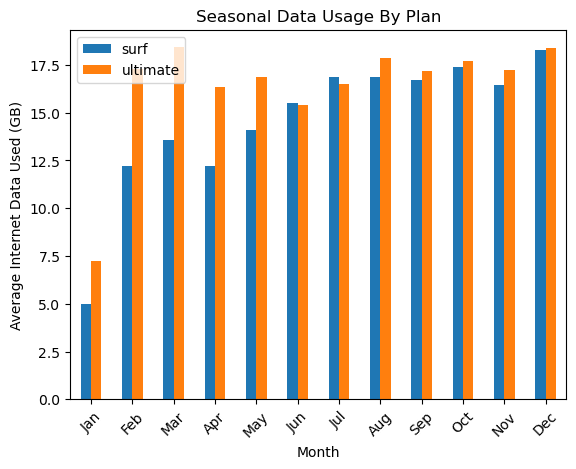

In [44]:
# Compare the number of gb users of each plan tend to use each month
av_gb_per_month_surf = surf_monthly_gb_used_data.groupby('month')['gb_used'].mean().rename('surf')
av_gb_per_month_ultimate = ultimate_monthly_gb_used_data.groupby('month')['gb_used'].mean().rename('ultimate')

av_gb_per_month_per_plan = pd.concat([
    av_gb_per_month_surf, av_gb_per_month_ultimate
    ], axis='columns').reset_index()

av_gb_per_month_per_plan.plot(x='month', kind='bar')
plt.title('Seasonal Data Usage By Plan')
plt.ylabel('Average Internet Data Used (GB)')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

Ultimate users tend to have higher data usage -- but primarily in the early months in the year. There are a couple months where Surf users outpace Ultimate users' data usage. As we will see below, this difference in the early months does not ultimately correspond

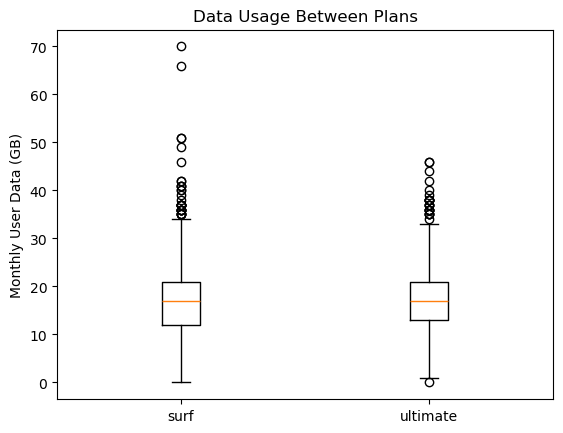

In [45]:
# Plot a boxplot to visualize the distribution of the monthly gb usage
plt.boxplot([surf_monthly_gb_used_data['gb_used'], ultimate_monthly_gb_used_data['gb_used']])
plt.xticks([1, 2], ['surf', 'ultimate'])
plt.ylabel('Monthly User Data (GB)')
plt.title('Data Usage Between Plans')
plt.show()

The boxplot is a great visualization of the average difference in plans. The distributions of data usage appear to be very similar. Let's look at the null hypothesis that the populations are equal:

In [46]:
# Means of the gb usage of each plan
av_surf_gb_used = surf_monthly_gb_used_data['gb_used'].mean()
av_ultimate_gb_used = ultimate_monthly_gb_used_data['gb_used'].mean()

# Print
print('Surf mean: {:.2f} GB'.format(av_surf_gb_used))
print('Ultimate mean: {:.2f} GB'.format(av_ultimate_gb_used))

# Test null hypothesis of equal population means
gb_results = st.ttest_ind(surf_monthly_gb_used_data['gb_used'], ultimate_monthly_gb_used_data['gb_used'], equal_var=False)
print(f"P value equals {gb_results.pvalue} and we cannot reject the null hypothesis under alpha of 0.05.")

Surf mean: 16.67 GB
Ultimate mean: 17.33 GB
P value equals 0.05942637578176711 and we cannot reject the null hypothesis under alpha of 0.05.


While there is no significant difference between data usage between plans, we can see that over half of Surf users go over their monthly data allotment of 15 GB of data. This is where most of the profitability of the Surf plan will come from, compared to message and call use. Only a small proportion of Ultimate users go over their monthly data allotment of 30 GB.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

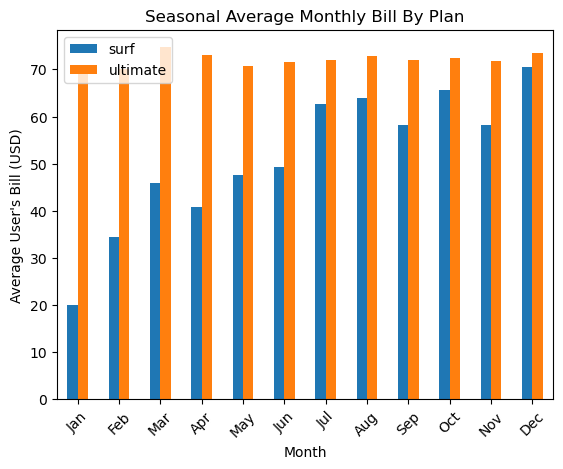

In [47]:
# Compare the average user revenue from each plan over the months (NOT GROSS REVENUE)
av_rev_per_user_per_month_surf = surf_monthly_user_data.groupby('month')['monthly_charge'].mean().rename('surf')
av_rev_per_user_per_ultimate = ultimate_monthly_user_data.groupby('month')['monthly_charge'].mean().rename('ultimate')

av_rev_per_user_per_plan = pd.concat([
    av_rev_per_user_per_month_surf, av_rev_per_user_per_ultimate
    ], axis='columns').reset_index()

av_rev_per_user_per_plan.plot(x='month', kind='bar')
plt.title('Seasonal Average Monthly Bill By Plan')
plt.ylabel('Average User\'s Bill (USD)')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

The average bill sent to each Ultimate customer does not fluctuate over the months, while the average Surf user increases as the year goes on, primarily driven by increased data usage.

More importantly, users on the Ultimate plan are always charged more on average, even when Surf users dramatically go past their monthly data usage and incur hefty costs. In terms of per-user profitability, the Ultimate plan wins out. 

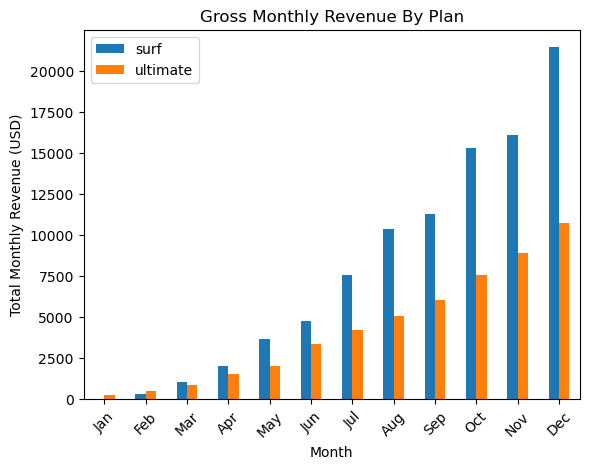

Surf Annual Gross Revenue: 93888.11 USD
Ultimate Annual Gross Revenue: 51226.00 USD
Total Annual Gross Revenue: 145114.11 USD


In [48]:
# Compare the gross revenue from each plan over the months (NOT GROSS REVENUE)
rev_per_month_surf = surf_monthly_user_data.groupby('month')['monthly_charge'].sum().rename('surf')
rev_per_month_ultimate = ultimate_monthly_user_data.groupby('month')['monthly_charge'].sum().rename('ultimate')

rev_per_month_per_plan = pd.concat([
    rev_per_month_surf, rev_per_month_ultimate
    ], axis='columns').reset_index()

rev_per_month_per_plan.plot(x='month', kind='bar')
plt.title('Gross Monthly Revenue By Plan')
plt.ylabel('Total Monthly Revenue (USD)')
plt.xlabel('Month')
plt.xticks(month_indices, month_labels)
plt.xticks(rotation=45)
plt.show()

# Print Annual Gross Revenue
print('Surf Annual Gross Revenue: {:.2f} USD'.format(rev_per_month_surf.sum()))
print('Ultimate Annual Gross Revenue: {:.2f} USD'.format(rev_per_month_ultimate.sum()))
print('Total Annual Gross Revenue: {:.2f} USD'.format(rev_per_month_surf.sum() + rev_per_month_ultimate.sum()))

The total revenue distribution from each plan roughly matches the user distribution demonstrated in Section 1.7.1. While we determined that the per-user profitability of the Ultimate plan was superior, because there are more than twice as many annual Surf users, the gross revenue generated from Surf users is greater.

## Test statistical hypotheses

We will first look at the first revenue set from the last section: comparing average monthly charges between plans. We believe the Ultimate plan mean is greater than the Surf plan mean, and so we will do a 1-sided t-test with the alternative hypothesis "The Ultimate plan monthly charge mean is greater than the Surf plan monthly charge mean." The null hypothesis is that "the Ultimate plan monthly charges are not significantly different than the Surf plan monthly charges. We'll use a strict critical significance level of 0.01.

In [49]:
# Test the hypotheses under strict critical significance
alpha = 0.01
av_revenue_results = st.ttest_1samp(ultimate_monthly_user_data['monthly_charge'], surf_monthly_user_data['monthly_charge'].mean())
surf_mean = surf_monthly_user_data['monthly_charge'].mean()
ultimate_mean = ultimate_monthly_user_data['monthly_charge'].mean()

# Print
print(f"P value equals {av_revenue_results.pvalue / 2}.")
if (av_revenue_results.pvalue / 2 < alpha) and (ultimate_mean > surf_mean):
    print('We can reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

P value equals 8.527589199170581e-112.
We can reject the null hypothesis.


The data would support the alternative hypothesis that the Ultimate plan monthly charge tends to be more than the Surf plan monthly charge.

Next, we have a suspicion that users in the NY-NJ area pay a different amount than the other regions. This alternative hypothesis is different from our past hypotheses as it does not care about what plan users are on. We'll split the data based only on user region, and compare the sample means with a 2-sided t-test since we don't care about whether it is greater or less than the other regions' monthly charges.

In [50]:
# Test the hypotheses
# New York-Newark-Jersey City, NY-NJ-PA MSA

# Test the hypotheses under moderate critical significance
alpha = 0.01
NY_revenues = agg_monthly_user_info.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_charge']
other_revenues = agg_monthly_user_info.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_charge']

NY_revenue_results = st.ttest_1samp(NY_revenues, other_revenues.mean())

# Print
print(f"P value equals {av_revenue_results.pvalue}.")
if av_revenue_results.pvalue < alpha:
    print('We can reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

P value equals 1.7055178398341162e-111.
We can reject the null hypothesis.


The data would support the alternative hypothesis that those from the NY-NJ area pay a different amount than the other regions.

## General conclusion

Our top conclusions, given that the Megaline commercial department wants to know which plan brings in more revenue, are firstly that Ultimate plan users on average pay more than Surf users. However, it is not so drastic a difference that they are necessarily the priority for marketing, as Surf users account for nearly twice the annual revenue (93,887.67 USD for Surf users compared to Ultimate users' 51,226.00 USD) and twice the number of clients (339 users in 2018 on Surf plan compared to 161 Ultimate users). Still, microeconomics cares about marginal revenue and cost per unit bought and sold, so from that perspective acquiring one more Ultimate user is statistically superior to acquiring one more Surf user.

One other important conclusion is that the Surf plan primarily generates income from users going over their data limit. We can see from the graphs in Section 1.7 that over half of Surf users went over their data limit, while virtually none of them went over their call or message limits. Section 1.8 showed us that the Ultimate average charge to users hovered just above 70 USD every month, which is the base cost of the plan ignoring additional overcharges. The Surf average charge to users, however, varied drastically, directly correlated to their data usage from Section 1.7.4.

Finally, our last conclusion is that some regions differ in their behavior and their profitability than others. The NY-NJ area has different behavior, for example, than the rest of the regions. It is worth looking at regional differences and regional profitability to determine the best markets to advertise.